# Session 3 

Exercises related to 'block 4' of the course on neural architectures for computer vision.) 

The motivation of this exercise is to get to grips with the pandas and PIL libraries for data and image manipulation, to study data transformation within PyTorch's data loaders, and to build a Siamese architecture based in part on a pre-trained classifier available in PyTorch models.

The exercise will consist in addressing the question of signature verification with a siamese network. Signature verification is a biometric task that is difficult because there are only tiny details between genuine and forged signatures. It consists in giving a pair of images representing 2 signatures and assessing whether the second is a genuine signature of the same person or a fake. 

Hence, the objective of this exercise is to develop a Siamese network capable of predicting whether two signatures are authentic or whether the second is an imitation made by a forger.

The method we ask you to implement is inspired by https://arxiv.org/pdf/1707.02131.pdf, which you can read if you want more information on the topic. Getting 75% of accuracy, assuming the test set includes half of the positive pairs and half of the negative pairs, seems reasonable. 

As seen in the course, Siamese Networks are based on the contrastive loss, which is defined in this paper http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf.

We are going to use images coming from this dataset:  http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2011_Signature_Verification_Competition_(SigComp2011)

We have at our disposal a training set with pairs of signatures.  Label 0 means that both signatures are authentic,  label 1 means that the second one is an imitation.

We have a second base (test) intended to measure the performance of the realized system.

That's it for this introduction, let's get to the heart of the subject.

# Step 1: let's prepare the environment

**Importing the required  packages**

If you don't know what they are for, ask your field instructor to explain.   

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


If you plan to use this notebook with google colab, next cell will be usefull to be able to access the dataset on google drive. Otherwise, you can just skip it.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Downloading the datasets and data files, defining the PATHs to the images**

All the data are available here: https://drive.google.com/drive/folders/1HOswvH42by9wsS26SbCqfRMfNeqGh6Xa
You have to clone this directory localy or on google drive if you plan to use google colab.
We have 2 different directories for train and test images. The `base_dir` contains the location of the main directory of the dataset and will depend on where you have downloaded the images.
If the Google Drive download fails, you can download the dataset on hugging face: https://huggingface.co/datasets/bensykes/dl_signatures/resolve/main/sign_data-20241017T094831Z-001.zip (run `!wget <hugging_face_link>` in a cell for simplicity)

In [ ]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/data/' #this variable should reflect the actual location of the data; to be updated according to where you put the data
training_dir = base_dir + 'sign_data/train/'
testing_dir  = base_dir + 'sign_data/test/'
import os

#let's see if the data are located at the right place:
for n in os.listdir(training_dir):
   print(n)
   break

036_forg


# Step2: loading and manipulating images with `PANDAS` and `PIL`.

Pandas is a data analysis and manipulation tool 
built on top of Python. You can access the documentation here: 
https://pandas.pydata.org 

It can manipulate a lot of data types, but we will mainly use it to read tabular data contains in a CSV file.

This file contains 3 columns per row, each row defining a pair of images and it's label (genuine or fake). The pairs have been prepared so you don't have to make them, but in the real life, you would have to do it.

The first column is the name of the first image of the pair, the second column is the name of the second image and the last is the class.

What you are asked to do here is to read the 2 CSV files `train_data.csv` and `test_data.csv` with PANDAs and convert them in two NumPy tensors denoted as `train_set_pairs` and `test_set_pairs`.

You will use `pd.read_csv()`. 

In [ ]:
import pandas as pd

def readAndConvertCsv(file):
# ...
# please insert your code here
# ...
  return np.array(l)

train_set_pairs = readAndConvertCsv(base_dir + "sign_data/train_data.csv")
test_set_pairs = readAndConvertCsv(base_dir + "sign_data/test_data.csv")

# let's check the shape of these 2 tensors
print(train_set_pairs.shape, test_set_pairs.shape)

# let's check the 2 first rows of each tensor
print(train_set_pairs[0,:], '\n' , test_set_pairs[0,:])

(23205, 3) (5747, 3)
['068/09_068.png' '068_forg/01_0124068.PNG' '1'] 
 ['068/09_068.png' '068_forg/01_0124068.PNG' '1']


**Let's now open images with PIL** 

You can have a look on the documentation of PIL: https://he-arc.github.io/livre-python/pillow/index.html

In the next cell, open the second image of the 3 first pairs of the train set and display it.

size of im  0 (155, 398, 3)
size of im  1 (141, 483, 3)
size of im  2 (166, 474, 3)


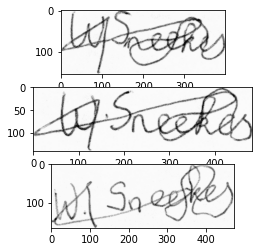

In [ ]:
import PIL
import matplotlib.pyplot as plt
n=3
fig, ax = plt.subplots(n)
for i in range(n):
  #... 
  # please insert your code here
  #... 
  print('size of im ',i,np.array(img).shape)
  ax[i].imshow(img)

**Resizing the images**

As you have seen, images have different sizes, which is not very convenient to use with neural nets. 

You will use the transformation contained in torchvision to resize them.

Please ask your field instructor to explain what is torchvision and how to use it.

Take the 3 same images as in the previous cell, resize them to 105x105 pixels and eventually convert them to PyTorch tensors of shape [1,3,105,105].


size of im  0 torch.Size([1, 3, 105, 105])
size of im  1 torch.Size([1, 3, 105, 105])
size of im  2 torch.Size([1, 3, 105, 105])


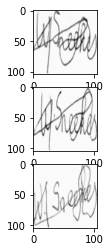

In [ ]:
import torchvision

transform=torchvision.transforms.Compose([torchvision.transforms.Resize((105,105)),torchvision.transforms.ToTensor()])

n=3
fig, ax = plt.subplots(n)
for i in range(n):
  #... 
  # please insert your code here
  #... 
  print('size of im ',i,img.shape)
  ax[i].imshow(img[0].permute(1,2,0))

**Making a PyTorch dataset**

Please ask your instructor to explain what a PyTorch dataset is. Documentation is available here: https://pytorch.org/vision/stable/datasets.html

Make a PyTorch dataset returning, for each item (ie for each pair), the 2 images resized to 105x105 and the label of the pair. 

In [ ]:
class SiameseNetworkDataset():    
    def __init__(self,pairs=None,base_dir=None,transform=None):
    #... 
    # please insert your code here
    #... 

    def __getitem__(self,index):
  #... 
  # please insert your code here
  #... 
    
    def __len__(self):
        return len(self.pairs)
Nx=105
Ny=105
train_set = SiameseNetworkDataset(train_set_pairs,base_dir=training_dir,transform=torchvision.transforms.Compose([torchvision.transforms.Resize((Nx,Ny)),torchvision.transforms.ToTensor()]))
test_set  = SiameseNetworkDataset(test_set_pairs,base_dir=testing_dir,transform=torchvision.transforms.Compose([torchvision.transforms.Resize((Nx,Ny)),torchvision.transforms.ToTensor()]))

print(train_set.__len__())
a,b,c = train_set.__getitem__(0)
print(a.shape,b.shape,c)


23205
torch.Size([3, 105, 105]) torch.Size([3, 105, 105]) tensor([1.])


**PyTorch DataLoaders**

You can now use the DataLoader class to automatically generate batches.

Look at the documentation and ask for help is needed. 

https://pytorch.org/docs/stable/data.html

labels [1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]


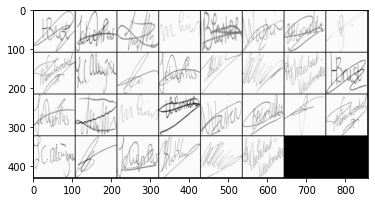

In [ ]:
batch = next(iter(torch.utils.data.DataLoader(train_set,shuffle=True, batch_size=15)))
image_set = torch.cat((batch[0],batch[1]),0)
plt.imshow(np.transpose(torchvision.utils.make_grid(image_set), (1, 2, 0)))
print('labels',batch[2].numpy().ravel())

#Step 3: defining the Siamese Network

The key idea is to use a pre-trained network as an encoding network and complete the Siamese network by adding extra layers. The siamese network takes 2 images and compute a distance between the two images. It hence returns a scalar value.

The whole will be finetuned.

You will use for this a pre-trained squeezenet1_0, which is quiete small, and replace the last classification layer. 

You will then complete the model to form a siamese network.  

In [ ]:
from torchvision.models import squeezenet1_0

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
        def forward(self, x):
        #... 
        # please insert your code here
        #... 

class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        #... 
        # please insert your code here
        #... 
    def forward(self, im1, im2):
       #... 
       # please insert your code here
       #... 

model = SiameseNetwork().to(device)

im0,im1,label = next(iter(torch.utils.data.DataLoader(train_set,shuffle=True, batch_size=15)))

output = model(im0.to(device),im1.to(device))
print(output.shape)


torch.Size([15])


# Step 4: defining the loss function and train the model

Now implement the standard contrastive loss defined by

$(1-y)*d^2 + y*\max(0,{margin}-d)^2$, where d is the distance between the two vectors 

In [ ]:
def ContrastiveLoss(d, label,margin=2):
  #... 
  # please insert your code here
  #... 


and train the model

In [ ]:
def train(net,train_dataloader):
    counter = []
    loss_history = [] 
    iteration_number= 0
    num_epochs = 1

    for epoch in range(0,num_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
             #... 
             # please insert your code here
             #... 
            if i %10 == 0 :
                print("Iterations {} Current loss {}".format(i*150/train_set.__len__(),loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

train_dataloader = torch.utils.data.DataLoader(train_set, shuffle=True,num_workers=1,batch_size=150)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
train(model,train_dataloader)
torch.save(model.state_dict(), base_dir+"model.pt")
print("Model Saved Successfully")

Iterations 0.0 Current loss 507.806396484375
Iterations 0.06464124111182935 Current loss 1.1555863618850708
Iterations 0.1292824822236587 Current loss 1.2023082971572876
Iterations 0.19392372333548805 Current loss 1.1196023225784302
Iterations 0.2585649644473174 Current loss 1.1527656316757202
Iterations 0.32320620555914675 Current loss 1.1319667100906372
Iterations 0.3878474466709761 Current loss 1.0351903438568115
Iterations 0.45248868778280543 Current loss 1.1019439697265625
Iterations 0.5171299288946348 Current loss 1.0882456302642822
Iterations 0.5817711700064642 Current loss 1.1221120357513428
Iterations 0.6464124111182935 Current loss 1.0919291973114014
Iterations 0.7110536522301228 Current loss 1.0992659330368042
Iterations 0.7756948933419522 Current loss 1.064767837524414
Iterations 0.8403361344537815 Current loss 1.0749530792236328
Iterations 0.9049773755656109 Current loss 1.080639362335205
Iterations 0.9696186166774402 Current loss 1.043567419052124
Model Saved Successfully

# Step 5: using the model to classify test pairs

If you already have a trained model, you can now load it.

In [ ]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(base_dir+"model.pt"))
_=model.eval() 

**Optimal threshold computation**

The model computes the similarity between two images. If the similarity is below a threshold, the pair will be classified as positive. Otherwise, the pair will be negative.

We now have to compute the optimal threshold for this task.

By calculating the average distance between the elements of the positive pairs and the average distance between the elements of the negative pairs, on the set train, estimate a distance threshold from which pairs can be considered to be positive.

In [ ]:
def calc_t():
    val_pos = list()
    val_neg = list()
    for i, data in enumerate(train_dataloader,0):
       #... 
       # please insert your code here
       #... 
    
train_dataloader = torch.utils.data.DataLoader(train_set, shuffle=True,num_workers=1,batch_size=32)
p,n=calc_t()
threshold = (p+n)/2
print(p,n,threshold)


0.67957747 0.90462047 0.7920989990234375


You can now make a dataloader for the test set.

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_set,num_workers=1,batch_size=1,shuffle=True)

**Performance evaluation**

Let's now evaluate the performance of the train network on the test set by measuring its accuracy.

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_set,num_workers=1,batch_size=32,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0): 
  #... 
  # please insert your code here
  #... 
  if i%50==0:
    print(i,float(correct)/counter)
accuracy =  float(correct)/counter
print("Accuracy:{}%".format(accuracy))

0 0.78125
50 0.7340686274509803
100 0.7388613861386139
150 0.7365480132450332
Accuracy:0.7339481468592309%
